# EDA

The goal of this EDA is to find extractable and useful features which can utilize the known characterastics of fake news, as well as to find unexpected features of fake news. There are tons of items to explore. Fun!

In [1]:
import pandas as pd
import numpy as np
import re

from nltk.help import upenn_tagset

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag, RegexpParser
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df0 = pd.read_csv('True.csv')
df1 = pd.read_csv('Fake.csv')

In [3]:
# Let's check how many valid entries we have

df0.drop_duplicate()

print(df0.info())
print(df1.info())

print(df0[df0.text.str.len()<10].count())
print(df1[df1.text.str.len()<10].count())
print(df0[df0.title.str.len()<10].count())
print(df1[df1.title.str.len()<10].count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None
title      1
text       1
subject    1
date       1
dtype: int64
title      651
text       651
subject    651
date       651
dtype: int64
title      0
text       0
subject    0
date       0
dtype: int64
title      1
text       1
subject    1
date

### Observation 1
- Unfortunately, this dataset doesn't contain the name of author. Empty or fake author name could be a strong feature which yield high precition.
- 2.8% of fake news **don't have texts**.

In [4]:
# Let's check a few examples of raw data

pd.options.display.max_colwidth = 200
#print(df0.head(20))
#print(df1.head(20))
#print('REAL NEWS:\n',df0.iloc[10][1])
#print('FAKE NEWS:\n',df1.iloc[10][1])

### Observation 2
- Real news sounds more informative, whereas fake news sounds **gossip**, although it's hard to tell why I feel that way. What's **relevant feature?**
- Interesting observation about **names** is that in the real news, they are either "title+full name" or "last name", whereas in fake news, they are sometimes **just full names without title**.
- "Subject" column doesn't seem to be useful
- From selective example, real news have more **quotations** whereas fake news have more **@** as their **source**.

Average title length in characters
Real: 64.667880655554 +- 9.168998728700778
Fake: 94.19803245176952 +- 27.184433137131766 

Average text length in characters
Real: 2383.278517065882 +- 1684.8357303747152
Fake: 2547.396235254035 +- 2532.8843992489196 

Average title length in number of words
Real: 9.954475416725032 +- 1.7007465775244577
Fake: 14.732805246795282 +- 4.335099114452772 

Average text length in number of words
Real: 385.6400989867862 +- 274.00620358361635
Fake: 423.1979046888974 +- 408.38889043663846 



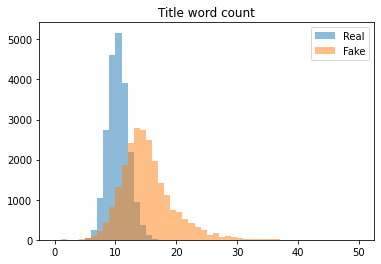

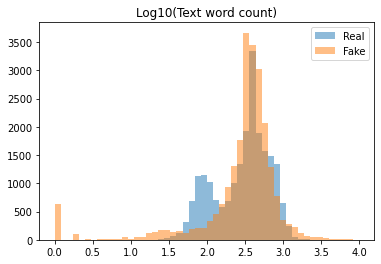

In [5]:
# Let's check 1. A. lack of information - does fake news has smaller size of text?

print("Average title length in characters")
print("Real:", df0.title.str.len().mean(),"+-",df0.title.str.len().std())
print("Fake:", df1.title.str.len().mean(),"+-",df1.title.str.len().std(),"\n")

print("Average text length in characters")
print("Real:", df0.text.str.len().mean(),"+-",df0.text.str.len().std())
print("Fake:", df1.text.str.len().mean(),"+-",df1.text.str.len().std(),"\n")

print("Average title length in number of words")
print("Real:", df0.title.str.split().str.len().mean(),"+-",df0.title.str.split().str.len().std())
print("Fake:", df1.title.str.split().str.len().mean(),"+-",df1.title.str.split().str.len().std(),"\n")

print("Average text length in number of words")
print("Real:", df0.text.str.split().str.len().mean(),"+-",df0.text.str.split().str.len().std())
print("Fake:", df1.text.str.split().str.len().mean(),"+-",df1.text.str.split().str.len().std(),"\n")

#plt.hist(df0.title.str.len(), alpha=0.5, range=(0,250), bins=50)
#plt.hist(df1.title.str.len(), alpha=0.5, range=(0,250), bins=50)
#plt.title("Title length")

#plt.legend(['Real','Fake']) 
#plt.show()

plt.hist(df0.title.str.split().str.len(), alpha=0.5, range=(0,50), bins=50)
plt.hist(df1.title.str.split().str.len(), alpha=0.5, range=(0,50), bins=50)
plt.title("Title word count")

plt.legend(['Real','Fake']) 
plt.show()

#plt.hist(np.log10(df0.text.str.len()), alpha=0.5, range=(0,5), bins=50)
#plt.hist(np.log10(df1.text.str.len()), alpha=0.5, range=(0,5), bins=50)
#plt.title("Log10(Text length)")

#plt.legend(['Real','Fake']) 
#plt.show()

plt.hist(np.log10(df0.text.str.split().str.len()+1), alpha=0.5, range=(0,4), bins=50)
plt.hist(np.log10(df1.text.str.split().str.len()+1), alpha=0.5, range=(0,4), bins=50)
plt.title("Log10(Text word count)")

plt.legend(['Real','Fake'])
plt.show()

### Observation 3
- I expected that fake news has much fewer text. Indeed, some of fake news have **extreamly short text size**. However, in most of cases, both real and fake news has similar amount of text, although whether they are informative or not is different story. Meanwhile, keep in mind that in this dataset, fake news have collected from website. We don't know what happens if we include social media.
- Real news has shorter title length with smaller standard deviation. That's seemingly because **briefness** is necessary for news title. **Long title length** can be a useful feature of fake news.
- Real news has **bimodal shape for text word count**. Probably they have two types of news length and authors strictly follow standard word count for each of them.

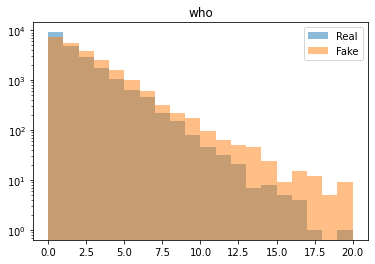

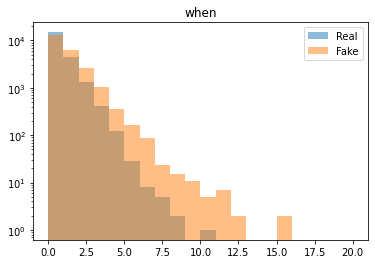

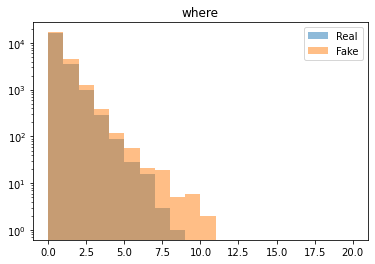

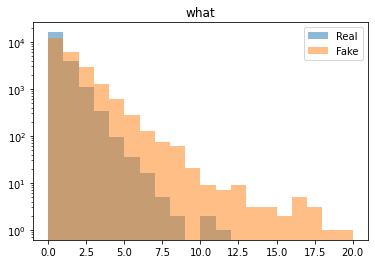

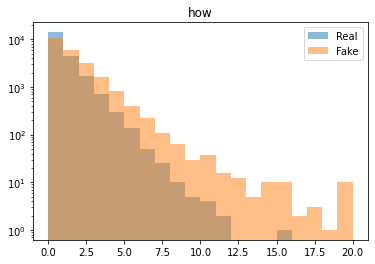

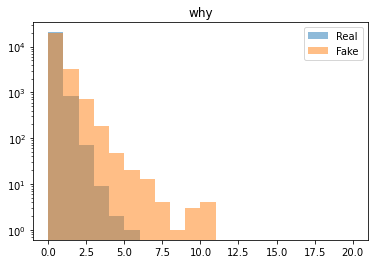

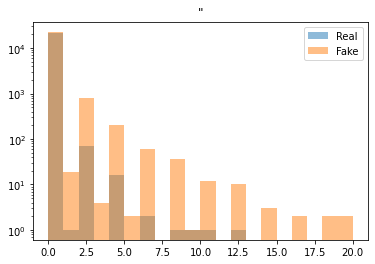

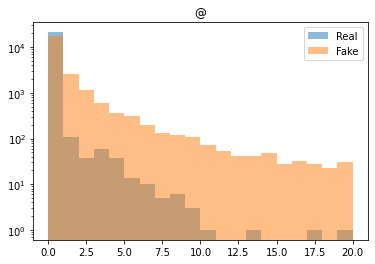

In [6]:
# Does fake news have less WH words that describe 5W1H? 

#n0 = df0.text.str.split().str.len().sum()#df0.text.count()
#n1 = df1.text.str.split().str.len().sum()#df1.text.count()

plt.hist(df0.text.str.count('who'), alpha=0.5, range=(0,20), bins=20, label='Real')
plt.hist(df1.text.str.count('who'), alpha=0.5, range=(0,20), bins=20, label='Fake')
plt.title("who")
plt.legend() 
plt.yscale('log')
plt.show()

plt.hist(df0.text.str.count('when'), alpha=0.5, range=(0,20), bins=20, label='Real')
plt.hist(df1.text.str.count('when'), alpha=0.5, range=(0,20), bins=20, label='Fake')
plt.title("when")
plt.legend() 
plt.yscale('log')
plt.show()

plt.hist(df0.text.str.count('where'), alpha=0.5, range=(0,20), bins=20, label='Real')
plt.hist(df1.text.str.count('where'), alpha=0.5, range=(0,20), bins=20, label='Fake')
plt.title("where")
plt.legend() 
plt.yscale('log')
plt.show()

plt.hist(df0.text.str.count('what'), alpha=0.5, range=(0,20), bins=20, label='Real')
plt.hist(df1.text.str.count('what'), alpha=0.5, range=(0,20), bins=20, label='Fake')
plt.title("what")
plt.legend() 
plt.yscale('log')
plt.show()

plt.hist(df0.text.str.count('how'), alpha=0.5, range=(0,20), bins=20, label='Real')
plt.hist(df1.text.str.count('how'), alpha=0.5, range=(0,20), bins=20, label='Fake')
plt.title("how")
plt.legend() 
plt.yscale('log')
plt.show()

plt.hist(df0.text.str.count('why'), alpha=0.5, range=(0,20), bins=20, label='Real')
plt.hist(df1.text.str.count('why'), alpha=0.5, range=(0,20), bins=20, label='Fake')
plt.title("why")
plt.legend() 
plt.yscale('log')
plt.show()

plt.hist(df0.text.str.count('\"'), alpha=0.5, range=(0,20), bins=20, label='Real')
plt.hist(df1.text.str.count('\"'), alpha=0.5, range=(0,20), bins=20, label='Fake')
plt.title("\"")
plt.legend() 
plt.yscale('log')
plt.show()

plt.hist(df0.text.str.count('@'), alpha=0.5, range=(0,20), bins=20, label='Real')
plt.hist(df1.text.str.count('@'), alpha=0.5, range=(0,20), bins=20, label='Fake')
plt.title("@")
plt.legend() 
plt.yscale('log')
plt.show()



### Observation 4
- Different from what I expected, using WHs words count alone don't look like a strong discriminator.
- Fake news use more '@'. It seems that's because fake news quote social media.

In [19]:
# Brute force word statistics, without text processing, in case frequently used keywords are not an alphabet, etc

title0 = df0.sample(1000).title.tolist()
title1 = df1.sample(1000).title.tolist()
text0 = df0.sample(1000).text.tolist()
text1 = df1.sample(1000).text.tolist()

def text2words(text):
    
    words_list = []
    
    for sentence in text:
    
        words = word_tokenize(sentence)
    
        for word in words:
            words_list.append(word)

    return words_list

title0 = text2words(title0)
title1 = text2words(title1)
text0 = text2words(text0)
text1 = text2words(text1)

In [29]:
word_counter = Counter(title0)
print('Title, Real:\n',word_counter.most_common(500))

word_counter = Counter(title1)
print('Title, Fake:\n',word_counter.most_common(500))

word_counter = Counter(text0)
print('Text, Real:\n',word_counter.most_common(100))

word_counter = Counter(text1)
print('Text, Fake:\n',word_counter.most_common(100))

Title, Real:
 [('to', 348), ('Trump', 265), (':', 241), (',', 230), ('in', 212), ('U.S.', 190), ("'s", 175), ('on', 168), ('of', 145), ('for', 142), ("'", 136), ('says', 125), ('House', 75), ('with', 73), ('North', 61), ('as', 53), ('over', 52), ('Korea', 46), ('Russia', 41), ('White', 39), ('vote', 34), ('China', 33), ('Senate', 33), ('Clinton', 32), ('after', 32), ('at', 31), ('from', 31), ('EU', 30), ('bill', 28), ('court', 27), ('new', 26), ('government', 26), ('deal', 26), ('by', 25), ('and', 25), ('probe', 25), ('Obama', 25), ('will', 24), ('talks', 24), ('not', 23), ('State', 23), ('New', 23), ('$', 22), ('U.N.', 22), ('Turkey', 22), ('Syria', 22), ('South', 20), ('Russian', 20), ('against', 20), ('Brexit', 20), ('minister', 20), ('Republican', 19), ('sanctions', 19), ('be', 19), ('-', 18), ('urges', 18), ('plan', 18), ('a', 18), ('Germany', 17), ('tax', 17), ('PM', 17), ('plans', 17), ('back', 17), ('Myanmar', 17), ('meeting', 16), ('governor', 16), ('defense', 16), ('lawmakers

In [69]:
# More stop word at fake news? If so, what kind?
# Different in grammar structure?

stop_words = set(stopwords.words('english'))

#print(stop_words)

def gramma_structure(words):
    
    tags = pos_tag(words)
    tags = [item[1] for item in tags]
      
    stops = [word for word in words if word in stop_words]
    means = [word for word in words if word not in stop_words]
    
    stop_tags = pos_tag(stops)
    stop_tags = [item[1] for item in stop_tags]

    mean_tags = pos_tag(means)
    mean_tags = [item[1] for item in mean_tags]
    
    
    counter_stop = Counter(stops)
    
    counter_mean = Counter(means)
    
    counter_tag = Counter(tags)
    
    counter_stoptag = Counter(stop_tags)
    
    counter_meantag = Counter(mean_tags)
    
    stop_fraction = len(stops)/len(words)
    
    
    return counter_stop, counter_mean, counter_tag, counter_stoptag, counter_meantag, stop_fraction


grammars = []

counter_stop, counter_mean, counter_tag, counter_stoptag, counter_meantag, stop_fraction = gramma_structure(title0)
grammars.append([counter_stop, counter_mean, counter_tag, counter_stoptag, counter_meantag, stop_fraction])
counter_stop, counter_mean, counter_tag, counter_stoptag, counter_meantag, stop_fraction = gramma_structure(title1)
grammars.append([counter_stop, counter_mean, counter_tag, counter_stoptag, counter_meantag, stop_fraction])
counter_stop, counter_mean, counter_tag, counter_stoptag, counter_meantag, stop_fraction = gramma_structure(text0)
grammars.append([counter_stop, counter_mean, counter_tag, counter_stoptag, counter_meantag, stop_fraction])
counter_stop, counter_mean, counter_tag, counter_stoptag, counter_meantag, stop_fraction = gramma_structure(text1)
grammars.append([counter_stop, counter_mean, counter_tag, counter_stoptag, counter_meantag, stop_fraction])

In [68]:
# Title
print('------Stop fraction')
print('Real\n',grammars[0][5])
print('Fake\n',grammars[1][5])

print('------Stop words')
print('Real\n',grammars[0][0].most_common(50))
print('Fake\n',grammars[1][0].most_common(50))

print('------Non-stop words')
print('Real\n',grammars[0][1].most_common(50))
print('Fake\n',grammars[1][1].most_common(50))

print('------Stop words tag')
print('Real\n',grammars[0][3].most_common(100))
print('Fake\n',grammars[1][3].most_common(100))

print('------Non-stop words tag')
print('Real\n',grammars[0][4].most_common(100))
print('Fake\n',grammars[1][4].most_common(100))

------Stop fraction
Real
 0
Fake
 0
------Stop words
Real
 [('to', 348), ('in', 212), ('on', 168), ('of', 145), ('for', 142), ('with', 73), ('as', 53), ('over', 52), ('after', 32), ('at', 31), ('from', 31), ('by', 25), ('and', 25), ('will', 24), ('not', 23), ('against', 20), ('be', 19), ('a', 18), ('up', 16), ('but', 16), ('no', 15), ('he', 15), ('before', 14), ('the', 12), ('is', 12), ('into', 11), ('out', 10), ('about', 9), ('an', 9), ('should', 9), ('have', 9), ('has', 9), ('more', 8), ('his', 8), ('this', 7), ('down', 7), ('if', 6), ('it', 6), ('than', 6), ('its', 6), ('off', 6), ('under', 6), ('all', 6), ('do', 5), ('or', 5), ('that', 5), ('can', 4), ('who', 4), ('during', 4), ('now', 4)]
Fake
 [('s', 262), ('t', 51), ('and', 44), ('to', 43), ('of', 40), ('the', 32), ('in', 30), ('a', 28), ('re', 22), ('is', 17), ('for', 13), ('with', 10), ('not', 9), ('that', 9), ('on', 9), ('by', 9), ('ve', 8), ('it', 7), ('ll', 6), ('are', 5), ('you', 5), ('m', 5), ('from', 5), ('this', 5), ('a

In [ ]:
# Text
print('------Stop fraction')
print('Real\n',grammars[2][5])
print('Fake\n',grammars[3][5])

print('------Stop words')
print('Real\n',grammars[2][0].most_common(50))
print('Fake\n',grammars[3][0].most_common(50))

print('------Non-stop words')
print('Real\n',grammars[2][1].most_common(50))
print('Fake\n',grammars[3][1].most_common(50))

print('------Stop words tag')
print('Real\n',grammars[2][3].most_common(100))
print('Fake\n',grammars[3][3].most_common(100))

print('------Non-stop words tag')
print('Real\n',grammars[2][4].most_common(100))
print('Fake\n',grammars[3][4].most_common(100))

In [ ]:

sentence = df0.sample(1).title.tolist()[0]


print(pos_tag(word_tokenize(sentence)))

## Text preprocessing

Now we want to explore further with words. To do so, we need to preprocess text first. Let's define useful functions first.

In [9]:
#print(upenn_tagset())

# nltk.pos_tag to lemmatizer input
def convert_pos(word):
    
    word_pos = pos_tag([word])
    
    tag = ''
    try:
        tag = word_pos[0][1][:2]
    except:
        tag = 'n'
    
    if tag == 'JJ':
        tag = 'a'
    elif tag == 'NN':
        tag = 'n'
    elif tag == 'RB':
        tag = 'r'
    elif tag == 'VB':
        tag = 'v'
    else:
        tag = 'n'
        
    return tag

# get lemmatized words
def get_root_words(corpus):
    
    lemmatizer = WordNetLemmatizer()
    
    word_list = []
    sentence_list =[]
    
    # Sentence tokenize
    sentences = sent_tokenize(corpus)

    # Stop word removal
    stop_words = set(stopwords.words('english'))

    
    for sentence in sentences:
        
        # remove non words, keep dots for abbreviation        

        if sentence[-1]!='.':
            print(sentence)
        
        else:
            sentence = sentence[:-1]


        sentence = re.sub('[.]','_',sentence)
        sentence = re.sub('\W+',' ',sentence)
        sentence = sentence.lower()
    
        # word tokenize 
        words = word_tokenize(sentence)
        # remove stop words
        words = [word for word in words if word not in stop_words]

        # lemmatize
        lemmatized = [lemmatizer.lemmatize(word, pos=convert_pos(word)) for word in words] 
        
        sentence_list.append(lemmatized)
        
        for word in lemmatized:
            word_list.append(word)
        
    return word_list, sentence_list

#print(get_root_words(df0.iloc[6][1])) # test

word_list, sentence_list = get_root_words(df0.iloc[6][1])

#def word_count(word_list):
    
word_counter = Counter(word_list)
    
print(word_counter.most_common(50))

[('trump', 15), ('say', 13), ('investigation', 6), ('u_s_', 5), ('mueller', 5), ('trade', 5), ('time', 4), ('know', 3), ('long', 3), ('would', 3), ('interview', 3), ('make', 3), ('base', 3), ('day', 3), ('west', 2), ('palm', 2), ('beach', 2), ('president', 2), ('thursday', 2), ('special', 2), ('counsel', 2), ('election', 2), ('probe', 2), ('last', 2), ('take', 2), ('week', 2), ('team', 2), ('republican', 2), ('russia', 2), ('democrat', 2), ('florida', 2), ('end', 2), ('told', 2), ('country', 2), ('look', 2), ('strong', 2), ('christmas', 2), ('united', 2), ('state', 2), ('north', 2), ('nafta', 2), ('canadian', 2), ('two', 2), ('fla', 1), ('reuters', 1), ('donald', 1), ('believe', 1), ('fairly', 1), ('treat', 1), ('russian', 1)]


### 

In [10]:
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('cannot', pos='n')

'cannot'

### Observation 4
- Abbreviation cuts

In [11]:
# Is there any single keywords that repeats a lot?







# Get a random text
text = df.iloc[6][3]

t = ['this is good', 'that is good', 'good hehe', 'this is bad', 'that is bad', 'bad sucks']
l = [0, 0, 0, 1, 1, 1]


counter = CountVectorizer()
counter.fit(t)


print(counter.vocabulary_)
print(counter.transform(t))


    
    

def chunk_counter(pos_text, abbr='NP', n_chunk=30):

    grammar = ''
    
    if abbr == 'Noun':
        grammar = "Noun: {<NN.*>}"
        
    elif abbr == 'Verb':
        grammar = "Verb: {<VB.*>}"
    
    elif abbr == 'Adj':
        grammar = 'Adj: {<JJ.*>}'
        
    elif abbr == 'Adv':
        grammar = 'Adv: {<RB.*>}'    
        
    #grammar = "NP: {<DT>?<JJ>*<NN.*>}" # noun
    #grammar = "VPa: {<DT>?<JJ>*<NN.*><VB.*><RB.?>?}"
    #grammar = "VPb: {<VB.*><DT>?<JJ>*<NN><RB.?>?}" 
    
    else:
        print('Incorrect gabbr')
        return False

        
    # Chunk phrases
    parser = RegexpParser(grammar)
    
    chunks = []
    
    for sentence in pos_text:
        
        chunk = parser.parse(sentence)
        
        for subtree in chunk.subtrees(filter=lambda t: t.label() == abbr):
            chunks.append(tuple(subtree))
        
    # Count phrases
    counter = Counter()

    for chunk in chunks:
        counter[chunk] += 1

    return counter.most_common(10)

print(chunk_counter(pos_text, abbr='Verb'))

NameError: name 'df' is not defined

In [ ]:
vectorizer = CountVectorizer()

vectorizer.fit(text)

X = vectorizer.transform(text)
y = label

print(vectorizer.vocabulary_)

In [ ]:
classifier = MultinomialNB()
classifier.fit(X,y)

In [ ]:
x = df_read.iloc[100]

print(x)

classifier.predict_proba(vectorizer.transform([x.content]))


In [ ]:


def train_test(df0, df1, n_train=100, fake_size=0.5):
    
    n_fake = int(n_train*fake_size)
    n_real = n_train-n_fake
    
    
    # Organize data
    
    train0, test0 = train_test_split(df0, test_size=0.5)
    train1, test1 = train_test_split(df1, test_size=0.5)
 
    train = pd.concat([train0.sample(n=n_train), train1.sample(n=n_train)])    
    test = pd.concat([test0.sample(n=n_real), test1.sample(n=n_fake)])
    
    train_text = train.text.tolist()
    train_labels = train.label.tolist()

    test_text = test.text.tolist()
    test_labels = test.label.tolist()
    
    
    # Training
      
    counter = CountVectorizer()

    counter.fit(train_text+test_text)

    train_counts = counter.transform(train_text)
    test_counts = counter.transform(test_text)

    classifier = MultinomialNB()
    classifier.fit(train_counts,train_labels)
    
    
    # Test
    predict = classifier.predict(test_counts)

    # n: real news, p: fake news
    tn, fp, fn, tp = confusion_matrix(test_labels,predict,labels=[0,1]).ravel()
    
    ac = accuracy_score(test_labels,predict)
    pr = precision_score(test_labels,predict)
    re = recall_score(test_labels,predict)
    f1 = f1_score(test_labels,predict)
    
    # when real news become target
    ipr = tn/(tn+fn)
    ire = tn/(tn+fp)
    if1 = 2*ipr*ire/(ipr+ire)
     
    return tn, fp, fn, tp, ac, pr, re, f1, ipr, ire, if1

#        tn, fp, fn, tp, ac, pr, re, f1, ipr, ire, if1 = train_test(df0, df1, n_train, fake_size)
#        result.append([n_train, fake_size, n_real, n_fake, ac, pr, re, f1, ipr, ire, if1])

#print(train_test(df0, df1, 100, 0.5))

After playing with the 'chunk_counter' function for a few sentences, I noticed that real news have more specific (you can guess topic based on keywords) and objective terms whereas fake news have more subjective and plain (no idea what's topic based on frequent keywords) terms.